<a href="https://colab.research.google.com/github/Janina712/MLTSA22_JBoecher/blob/main/HW4/HW4_JBoecher_Resubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FBB REVISIONS WERE VERY GIID - just a few comments below

This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [ ]:
!pip install wwo-hist

In [ ]:
import pandas as pd
import pylab as pl
import matplotlib as plt
from numpy.ma.core import std
from wwo_hist import retrieve_hist_data
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


In [ ]:
!pip install fbprophet


In [ ]:
import fbprophet

In [ ]:
from fbprophet import Prophet
from fbprophet import diagnostics

# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [ ]:
global uberrides
uberrides = pd.DataFrame()

for mon in ['apr', 'may', 'jun', 'jul', 'aug', 'sep']:
    #print(mon)
    uberrides_mon = pd.read_csv(f"https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-{mon}14.csv")
    uberrides = pd.concat([uberrides_mon, uberrides], ignore_index=True) 

In [ ]:
print(uberrides)

                  Date/Time      Lat      Lon    Base
0          9/1/2014 0:01:00  40.2201 -74.0021  B02512
1          9/1/2014 0:01:00  40.7500 -74.0027  B02512
2          9/1/2014 0:03:00  40.7559 -73.9864  B02512
3          9/1/2014 0:06:00  40.7450 -73.9889  B02512
4          9/1/2014 0:11:00  40.8145 -73.9444  B02512
...                     ...      ...      ...     ...
4534322  4/30/2014 23:22:00  40.7640 -73.9744  B02764
4534323  4/30/2014 23:26:00  40.7629 -73.9672  B02764
4534324  4/30/2014 23:31:00  40.7443 -73.9889  B02764
4534325  4/30/2014 23:32:00  40.6756 -73.9405  B02764
4534326  4/30/2014 23:48:00  40.6880 -73.9608  B02764

[4534327 rows x 4 columns]


**Comment:** Read in original raw data files from URL. Data files were available for each individual month (April through October). The six separate data files were then appended to a single dataframe. 

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [ ]:
uberrides["Date/Time"]

0            9/1/2014 0:01:00
1            9/1/2014 0:01:00
2            9/1/2014 0:03:00
3            9/1/2014 0:06:00
4            9/1/2014 0:11:00
                  ...        
4534322    4/30/2014 23:22:00
4534323    4/30/2014 23:26:00
4534324    4/30/2014 23:31:00
4534325    4/30/2014 23:32:00
4534326    4/30/2014 23:48:00
Name: Date/Time, Length: 4534327, dtype: object

In [ ]:
uberrides["time"] = pd.to_datetime(uberrides["Date/Time"])

In [ ]:
uberbyday = uberrides.groupby([uberrides["time"].dt.date]).count()
uberbyday.tail()

,Date/Time,Lat,Lon,Base,time
time,,,,,
2014-09-26,37504,37504,37504,37504,37504
2014-09-27,39468,39468,39468,39468,39468
2014-09-28,29656,29656,29656,29656,29656
2014-09-29,29201,29201,29201,29201,29201
2014-09-30,33431,33431,33431,33431,33431


In [ ]:
uberbyday.rename({"time":"y"}, axis =1, inplace = True)

In [ ]:
uberbyday.reset_index(inplace=True)

In [ ]:
uberbyday.rename({"time":"ds"}, axis =1, inplace = True)

In [ ]:
uberbyday.drop('Date/Time', axis=1, inplace=True)
uberbyday.drop('Lat', axis=1, inplace=True)
uberbyday.drop('Lon', axis=1, inplace=True)
uberbyday.drop('Base', axis=1, inplace=True)

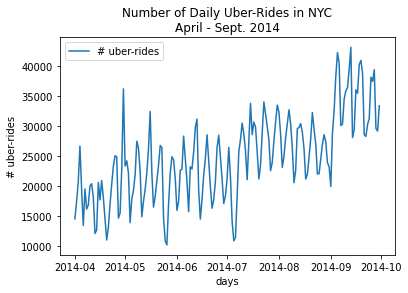

In [ ]:
uberbyday.plot(x="ds", y="y")
plt.xlabel("days")
plt.title("Number of Daily Uber-Rides in NYC\nApril - Sept. 2014")
plt.ylabel("# uber-rides")
plt.legend(["# uber-rides"])
plt.show()

**Fig.1.** Number of daily uber-rides in New York City between April and September 2014. Overall, the data exhibit a gradual growth trend. The pattern is further characterized by short-term periodicity and an abrupt change in behavior near 2014/09. Some data points do not fit what would be expected based on the general data pattern. Below, models will be built to incrementally account for each of these defining characteristics separately. 

**Comment:** Data frame has been re-organized to fit the format required by the FB prophet package. Specifically, the data/time column was converted to datetime type, which allows grouping by date. Additionally, row and column headers were renamed to fit the fb prophet requirements and unnecessary columns were deleted ("y" and "ds" are required variable names. To clarify what the variables mean, the x and y labels were updated in the plot). Now, the data frame contains the number of uber-rides per day in each data cell. 

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

In [ ]:
uberbyday["y"] = (uberbyday["y"]- uberbyday["y"].mean())/(std(uberbyday["y"]))

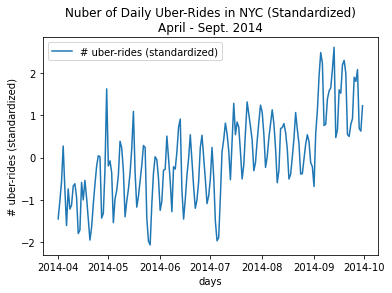

In [ ]:
uberbyday.plot(x="ds", y="y");
plt.xlabel("days")
plt.title("Nuber of Daily Uber-Rides in NYC (Standardized)\nApril - Sept. 2014")
plt.ylabel("# uber-rides (standardized)")
plt.legend(["# uber-rides (standardized)"])
plt.show()

**Fig.2.** Standardized number of daily uber-rides in New York City between April and September 2014. The plot contains the same information as fig. 1., except the values are standardized.

**Comment:** Number of daily uber-rides was standardized by subtracting the average number of daily uber-rides from each daily value and dividing by the standard deviation of daily uber-rides.  

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [ ]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = simplem.make_future_dataframe(periods=30)
future.index.name = 'Total # of days in model'
future.tail()

,ds
Total # of days in model,
208,2014-10-26
209,2014-10-27
210,2014-10-28
211,2014-10-29
212,2014-10-30


**Comment:** Based on six months of data, daily uber-rides will predicted for the month of October. In this step, more rows are added to the original data frame to accomodate the prediction values, which will be modelled in the next step. The tail of the new data frame is plotted to ensure that the Octobre rows have been added.

"ds" means "date". The variable name can't be changed, because the predict method needs "ds".

In [ ]:
forecast = simplem.predict(future)
forecast.index.name = 'Total # of days in model'
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
Total # of days in model,,,,
208,2014-10-26,0.682221,-0.008438,1.363503
209,2014-10-27,0.960668,0.289092,1.637978
210,2014-10-28,1.537100,0.861294,2.221854
211,2014-10-29,1.893875,1.223620,2.558179
212,2014-10-30,2.212295,1.488484,2.889495


**Comment:** The predict method was used to calculate the expected number of daily uber-rides based on the simple model (yhat, dark-solid line in plot below). The lower and upper boundary of the confidence interval (80% by default) are represented as yhat_lower and yhat_upper respectively (CI: light-blue shaded area in plot below).  

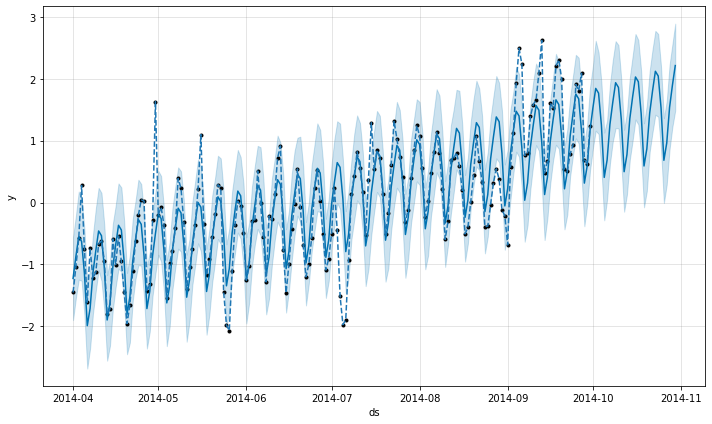

In [ ]:
fig1 = simplem.plot(forecast)
pl.plot(uberbyday.ds, uberbyday.y, '--')

**Fig.3.** Forecast of number of uber-rides for October 2014 based on a simple prophet model that considers trend and seasonality. 

The observed data points are represented by the back dots. A dashed line connects the observables. The solid blue line represents the expected values calculated by the model (yhat). The blue shaded region is the uncertainty interval (80%, yhat_lower to yhat_upper). 

The model captures the overall shape of the data fairly well. However, certain data points are outside the confidence interval of the model. Initially, these data points seem to be sporadic (perhaps due to special events, such as holidays), while towards September, the model seems to lose accuracy more consistently. This is probably due to the sudden change in behavior of the data around this time. 

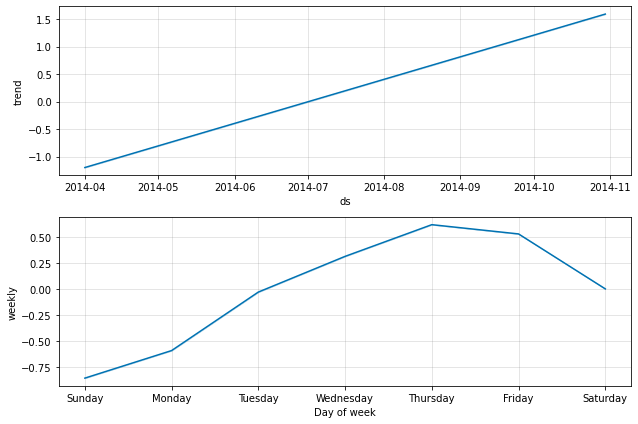

In [ ]:
fig2 = simplem.plot_components(forecast)

**Fig.4.** Breakdown of trend and seasonality components that determine the timeseries data. There is a linear upward trend from April to the end of September. Further, most uber-rides seem to happen towards the weekend of each week with a peak on Thursdays introducing a weekly seasonality pattern into the data.

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [ ]:
diagnostics.cross_validation?

In [ ]:
def rchi2(y, ytrue):
    chi2 = sum(((ytrue - y)**2)/ytrue)
    rchi2 = chi2/(len(ytrue) - 1)
    return rchi2

cvresult_simplem = diagnostics.cross_validation(simplem, horizon = '30 days')
print(cvresult_simplem)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

            ds      yhat  yhat_lower  yhat_upper         y     cutoff
0   2014-07-03  0.475747   -0.046321    1.005283 -0.451851 2014-07-02
1   2014-07-04  0.476141   -0.052839    0.987675 -1.510044 2014-07-02
2   2014-07-05 -0.263725   -0.807477    0.266288 -1.972870 2014-07-02
3   2014-07-06 -1.076936   -1.625277   -0.580891 -1.894312 2014-07-02
4   2014-07-07 -0.724506   -1.217528   -0.245259 -0.923059 2014-07-02
..         ...       ...         ...         ...       ...        ...
145 2014-09-26  1.162421    0.593916    1.756956  1.807871 2014-08-31
146 2014-09-27  0.541981   -0.048343    1.138691  2.086874 2014-08-31
147 2014-09-28 -0.166411   -0.773150    0.447430  0.692997 2014-08-31
148 2014-09-29  0.185724   -0.376941    0.782465  0.628361 2014-08-31
149 2014-09-30  0.712232    0.091462    1.333910  1.229268 2014-08-31

[150 rows x 6 columns]


In [ ]:
rchi2(cvresult_simplem["yhat"],cvresult_simplem["y"])

0.501333729326945

**Comment:** The reduced chi square value is a measure of goodness of fit of the model. It is obtained by dividing the chi-square value by the number of degrees of freedom. A perfect model would have a reduced chi-square value of 1. Values further away from 1 represent poorer models. Values > 1 indicate that the model doesn't capture all the data. Values < 1 indicate that the model is an overfit of the data, e.g., the error varaince is over-stimated. 

The result for model 1 is rchi2 = 0.50. This suggests that the model overfits the data. Since the uncertainties are not considered in this function, a value smaller than 1 was expected. 

# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [ ]:
!pip install wwo_hist

In [ ]:
from google.colab import drive #Normally at the beginning of notebook. Left here because data download takes place here. 

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive/MyDrive/ColabNotebooks

/content/gdrive/MyDrive/ColabNotebooks


In [ ]:
frequency = 24 #fewquency in hours
start_date = pd.to_datetime('2014-4-1')
end_date =  pd.to_datetime('2014-9-30')
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:00.986882
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.023609
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:03.293922
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:04.798042
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:06.231034
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:07.504427


export New+york,ny completed!




In [ ]:
weather = pd.read_csv("New+york,ny.csv")
tempC = weather.tempC
precipMM = weather.precipMM

In [ ]:
uberbyday

,ds,y
0,2014-04-01,-1.453505
1,2014-04-02,-1.037558
2,2014-04-03,-0.579136
3,2014-04-04,0.275062
4,2014-04-05,-0.746764
...,...,...
178,2014-09-26,1.807871
179,2014-09-27,2.086874
180,2014-09-28,0.692997
181,2014-09-29,0.628361


In [ ]:
uberweather = uberbyday.join(weather.tempC)
uberweather = uberweather.join(weather.precipMM)
uberweather            

,ds,y,tempC,precipMM
0,2014-04-01,-1.453505,13,0.0
1,2014-04-02,-1.037558,13,0.9
2,2014-04-03,-0.579136,15,0.0
3,2014-04-04,0.275062,7,10.7
4,2014-04-05,-0.746764,10,3.7
...,...,...,...,...
178,2014-09-26,1.807871,27,0.0
179,2014-09-27,2.086874,30,0.0
180,2014-09-28,0.692997,26,0.0
181,2014-09-29,0.628361,25,0.2


In [ ]:
#standardize
uberweather["tempC"] = (uberweather["tempC"]- uberweather["tempC"].mean())/(std(uberweather["tempC"]))
uberweather["precipMM"] = (uberweather["precipMM"]- uberweather["precipMM"].mean())/(std(uberweather["precipMM"]))

In [ ]:
#leave
uberweather

,ds,y,tempC,precipMM
0,2014-04-01,-1.453505,-1.754921,-0.574075
1,2014-04-02,-1.037558,-1.754921,-0.473233
2,2014-04-03,-0.579136,-1.389562,-0.574075
3,2014-04-04,0.275062,-2.850998,0.624833
4,2014-04-05,-0.746764,-2.302960,-0.159499
...,...,...,...,...
178,2014-09-26,1.807871,0.802592,-0.574075
179,2014-09-27,2.086874,1.350630,-0.574075
180,2014-09-28,0.692997,0.619912,-0.574075
181,2014-09-29,0.628361,0.437233,-0.551666


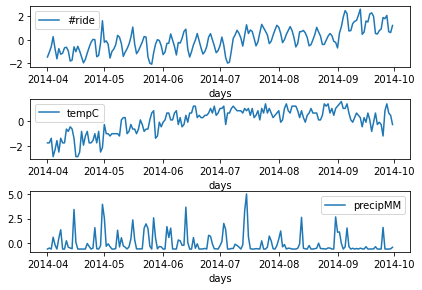

In [ ]:
fig, ax = pl.subplots(3)
fig.tight_layout()
uberweather.plot(x = "ds", y="y", ax=ax[0], xlabel = "days", label = "#ride")
uberweather.plot(x = "ds", y="tempC", ax=ax[1], xlabel = "days")
uberweather.plot(x = "ds", y="precipMM", ax=ax[2],  xlabel = "days");

**Fig.5.** Standardized plots of #daily uberrides, temperature, and precipitation for the time from April to September 2014. Subplot 1 is the same as figure 2. Subplot 2 shows daily temperature, which rises until it reaches a peak during July and Aug. and starts to drop in September. Subpot 3 shows precipitation. There are fairly regular peaks throughout, but they are more common until August. The largest peak happens in July. The drop in temperature in September may contribute to the sudden increase in uber-rides.

**Comment:** In this section, I downloaded weather data for the time from April to September 2015. The variables from the weather data I used were daily average temparature and amount of precipitation. These data were joint with the data on number of daily uber-rides in a new data frame called uberweather. The data from all the three columns is plotted in corresponding subplots in fig. 5.  

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [ ]:
regrm = Prophet()
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')

In [ ]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


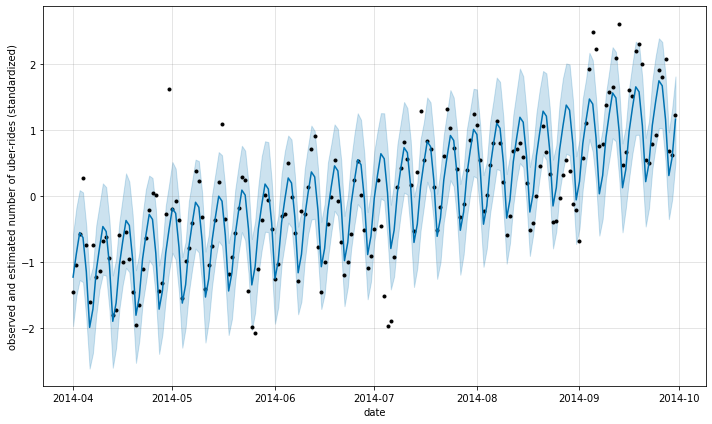

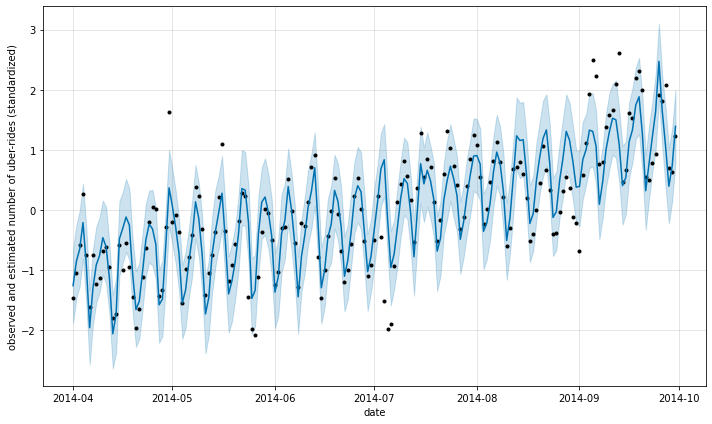

In [ ]:
nowcast = simplem.predict(uberbyday)
simplem.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)")
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)");

**Fig.6**. #Uber-rides according to the fb prophet simple model (1/fig.3) and the model with weather added as a regressor (2). 

Comparing the models by inspecting the plots, it can be said that the model with added weather regressors captures the data better than the simple model. The three data points in early July are now closer to the uncertainty interval than before. Similarly, one of the points outside the uncertainty interval in May is now closer. However, the point at 2014/09 that was in the uncertainty region is now outside. Yet, the regrm model seems to account for the data better than the simple model.

In [ ]:
cvresult_regrm = diagnostics.cross_validation(regrm, horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(cvresult_regrm["yhat"],cvresult_regrm["y"])

0.48552831163062626

**Comment**: The reduced chi-squared value assoicated with model 2 is rchi2 = 0.49. This result indicates a goodness of fit that is only marginally different from model 1. According to this measure, the model overfits the data slightly more than model 1. This makes sense because the additional regressors introduce more potential error variance. 

**Comment:**Here, I added the temperature and precipitation as regressors to the simple model. I compared how well this expanded model captures the data compared to the original simple model that contains only trend and seasonaility.

# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [ ]:
regholm = Prophet()
regholm.add_country_holidays(country_name = "US")

In [ ]:
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


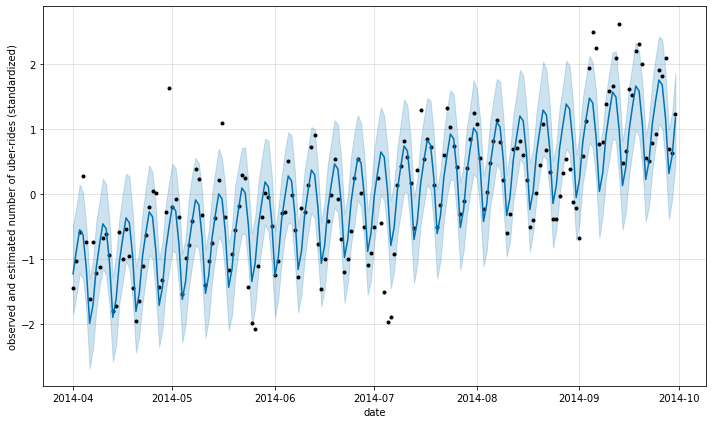

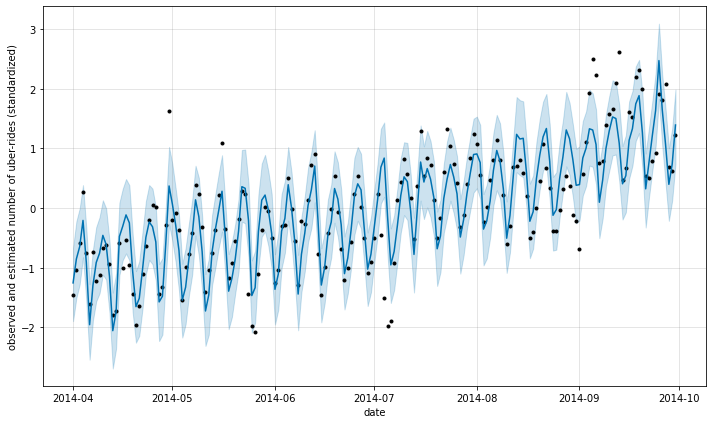

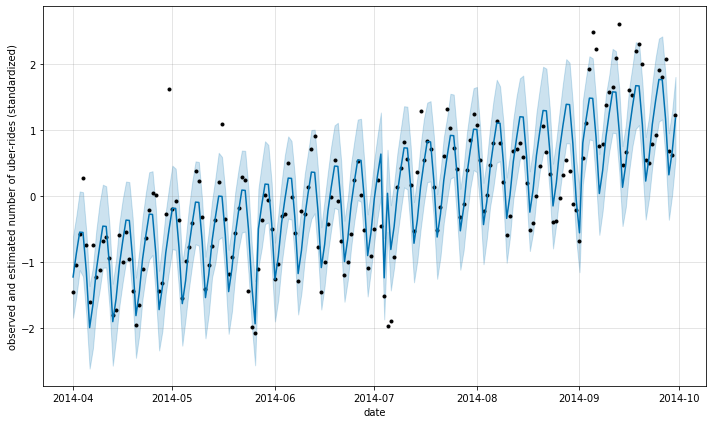

In [ ]:
nowcast = simplem.predict(uberbyday)
simplem.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)")
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)")
nowcast = regholm.predict(uberweather)
regholm.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)");

**Fig.7**. #Uber-rides according to the fb prophet simple model (1), the model with weather added as a regressor (2), and the model that takes holidays into consideration (3). 

Model 3 that considers holidays captures some of the data points that were previously outside the uncertainty interval. Specifically, data points in early July (4th of July) and and early September (Labor Day) are now (almost) within the uncertainty interval of the model. Model 3 constitutes an improvement compared to previous models.

In [ ]:
cvresult_regholm = diagnostics.cross_validation(regholm, horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(cvresult_regholm["yhat"],cvresult_regholm["y"])

0.46186850967884535

**Comment**: The reduced chi-squared value of model 3 is rchi2 = 0.46. This result indicates a goodness of fit that is somewhat different from model 1 and 2. According to this measure, the model overfits the data slightly more than model 1 and 2. This makes sense because yet another factor is introduced that increases the potential variance of errors. 

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [ ]:
regmcmc = Prophet(mcmc_samples=5000)

In [ ]:
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


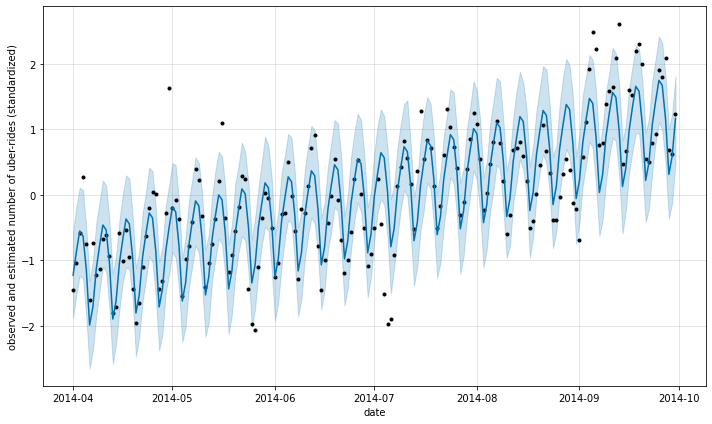

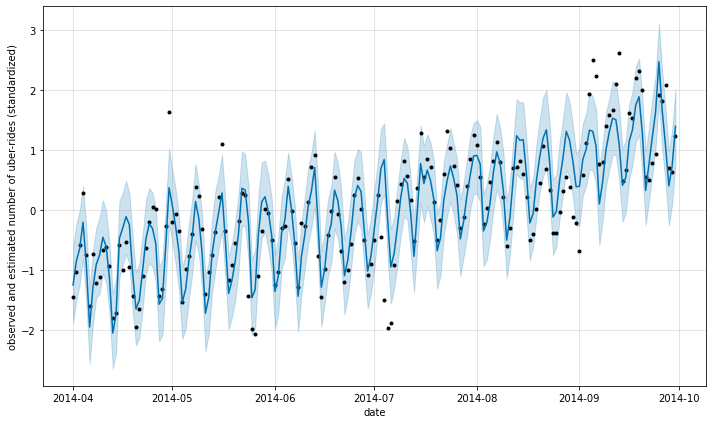

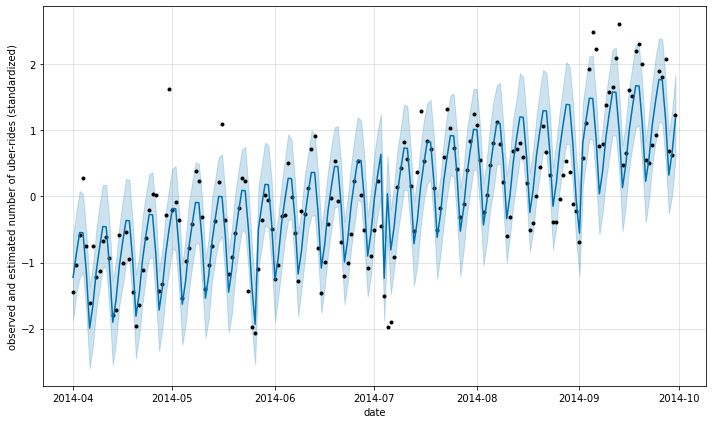

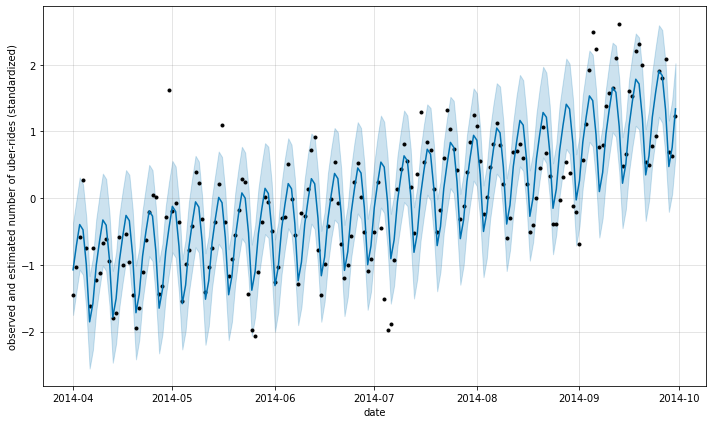

In [ ]:
nowcast = simplem.predict(uberbyday)
simplem.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)")
nowcast = regrm.predict(uberweather)
regrm.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)")
nowcast = regholm.predict(uberweather)
regholm.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)")
nowcast = regmcmc.predict(uberweather)
regmcmc.plot(nowcast, xlabel = "date", ylabel = "observed and estimated number of uber-rides (standardized)");

**Fig.8.** #Uber-rides according to the fb prophet simple model (1), the model with weather added as a regressor (2), the model that takes holidays into consideration (3), and Bayesian framework model (4).

Model 4 is very similar to model 3 in terms of goodness of fit, judging from inspecting the plots. Merely one of the data points in early July and one in early September is now slightly outside the uncertainty interval.

In [ ]:
cvresult_regmcmc = diagnostics.cross_validation(regholm, horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
rchi2(cvresult_regmcmc["yhat"],cvresult_regmcmc["y"])

0.46186850967884535

**Comment:** The reduced chi-squared value of model 4 is rchi2 = 0.46. This result indicates a goodness of fit that is the same as model 3. According to this measure, the model overfits the data slightly more than model 1 and 2. The additative model including trend, seasonality, weather regressors, and holidays has the same goodness of fit measure as the Bayesian framework mode. 

# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm